In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
from analysis_utilities import aggregate_by_time_and_plot, aggregate_by_event_time_and_plot, \
    select_controls, test_balance, add_missing_indicators, prepare_df, generate_variable_names

plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
import pandas as pd

# Store paths.
INPUT_DATA = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/data/03_cleaned/crime_analysis.csv"
OUTPUT_FIGURES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_90m/figures"
OUTPUT_TABLES = "/Users/arjunshanmugam/Documents/GitHub/seniorthesis/output/crime_90m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_csv(INPUT_DATA)

analysis='group_1_crimes_150m'

In [2]:
value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = generate_variable_names(analysis=analysis)

# Uncomment below line for "any crime" analysis
# import numpy as np
# df[value_vars_crime] = np.where(df[value_vars_crime] > 0, 1, 0)

In [3]:
covariates_exploration_df = select_controls(df=df, analysis=analysis, output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Assault-Related Crime Incidents Within 150m, Oct. 2022   
                                                 \emph{Independent Variable}                                                                          
Panel A: Pre-treatment Outcomes                  twenty_seventeen_group_1_crimes_150m                                             5.728125e-125       
                                                 pre_treatment_change_in_group_1_crimes_150m                                       3.994933e-01       
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                                4.739427e-09       
                                                 med_hhinc2016                                                                     5.803857e-01       
                                                 poor_share2010                                                                    1.893895e-04       
                                                 share_white2010                                                                   2.536565e-05       
                                                 traveltime15_2010                                                                 2.668774e-36       
Panel C: Case Initiation                         for_cause                                                                         3.075077e-01       
                                                 no_cause                                                                          8.353397e-02       
                                                 non_payment                                                                       3.775566e-02       
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                          4.738400e-01       
                                                 hasAttyP                                                                          7.253602e-02       
                                                 isEntityD                                                                         7.973117e-01       
                                                 isEntityP                                                                         9.033737e-04       

                                                                                                                
                                                                                             Plaintiff Victory  
                                                 \emph{Independent Variable}                                    
Panel A: Pre-treatment Outcomes                  twenty_seventeen_group_1_crimes_150m             4.933944e-02  
                                                 pre_treatment_change_in_group_1_crimes_150m      4.473736e-01  
Panel B: Census Tract Characteristics            frac_coll_plus2010                               2.403331e-01  
                                                 med_hhinc2016                                    1.910501e-01  
                                                 poor_share2010                                   1.428679e-01  
                                                 share_white2010                                  9.829904e-02  
                                                 traveltime15_2010                                2.271578e-01  
Panel C: Case Initiation                         for_cause                                        4.801045e-01  
                                                 no_cause                                         3.835665e-05  
                                                 non_payment                                      2.880676e-03  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                   

In [4]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A twenty_seventeen_group_1_crimes_150m               0.862015   
Panel B frac_coll_plus2010                                 0.322882   
        poor_share2010                                     0.273292   
        share_white2010                                    0.312272   
        traveltime15_2010                                  0.162315   
Panel C non_payment                                        0.781742   
Panel D isEntityP                                          0.808499   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A twenty_seventeen_group_1_crimes_150m                             0.138714   
Panel B frac_coll_plus2010                                               0.014179   
        poor_share2010                                                   0.011240   
        share_white2010                                                  0.024618   
        traveltime15_2010                                                0.005986   
Panel C non_payment                                                      0.068150   
Panel D isEntityP                                                        0.099762   

                                                                            
                                              \emph{p}  Weighted  \emph{p}  
Panel A twenty_seventeen_group_1_crimes_150m  0.049339  0.028398  0.675542  
Panel B frac_coll_plus2010                    0.240333 -0.006118  0.595627  
        poor_share2010                        0.142868 -0.005516  0.433171  
        share_white2010                       0.098299 -0.001080  0.939244  
        traveltime15_2010                     0.227158 -0.003582  0.440859  
Panel C non_payment                           0.002881  0.000188  0.992138  
Panel D isEntityP                             0.000006  0.013179  0.376928

In [6]:
# Store treatment date variable -- may be either file_date or latest_docket_date -- and drop rows where missing.
treatment_date_variable = 'file_date'
treatment_month_variable = treatment_date_variable.replace('date', 'month')

# Generate indicators for missing data.
missing_indicators = []
# Prepare df for use with the differences package.
df = prepare_df(df, analysis, treatment_date_variable, pre_treatment_covariates, missing_indicators, value_vars_crime, month_to_int_dictionary)

In [7]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 2184/2184 [00:13<00:00, 162.64it/s]


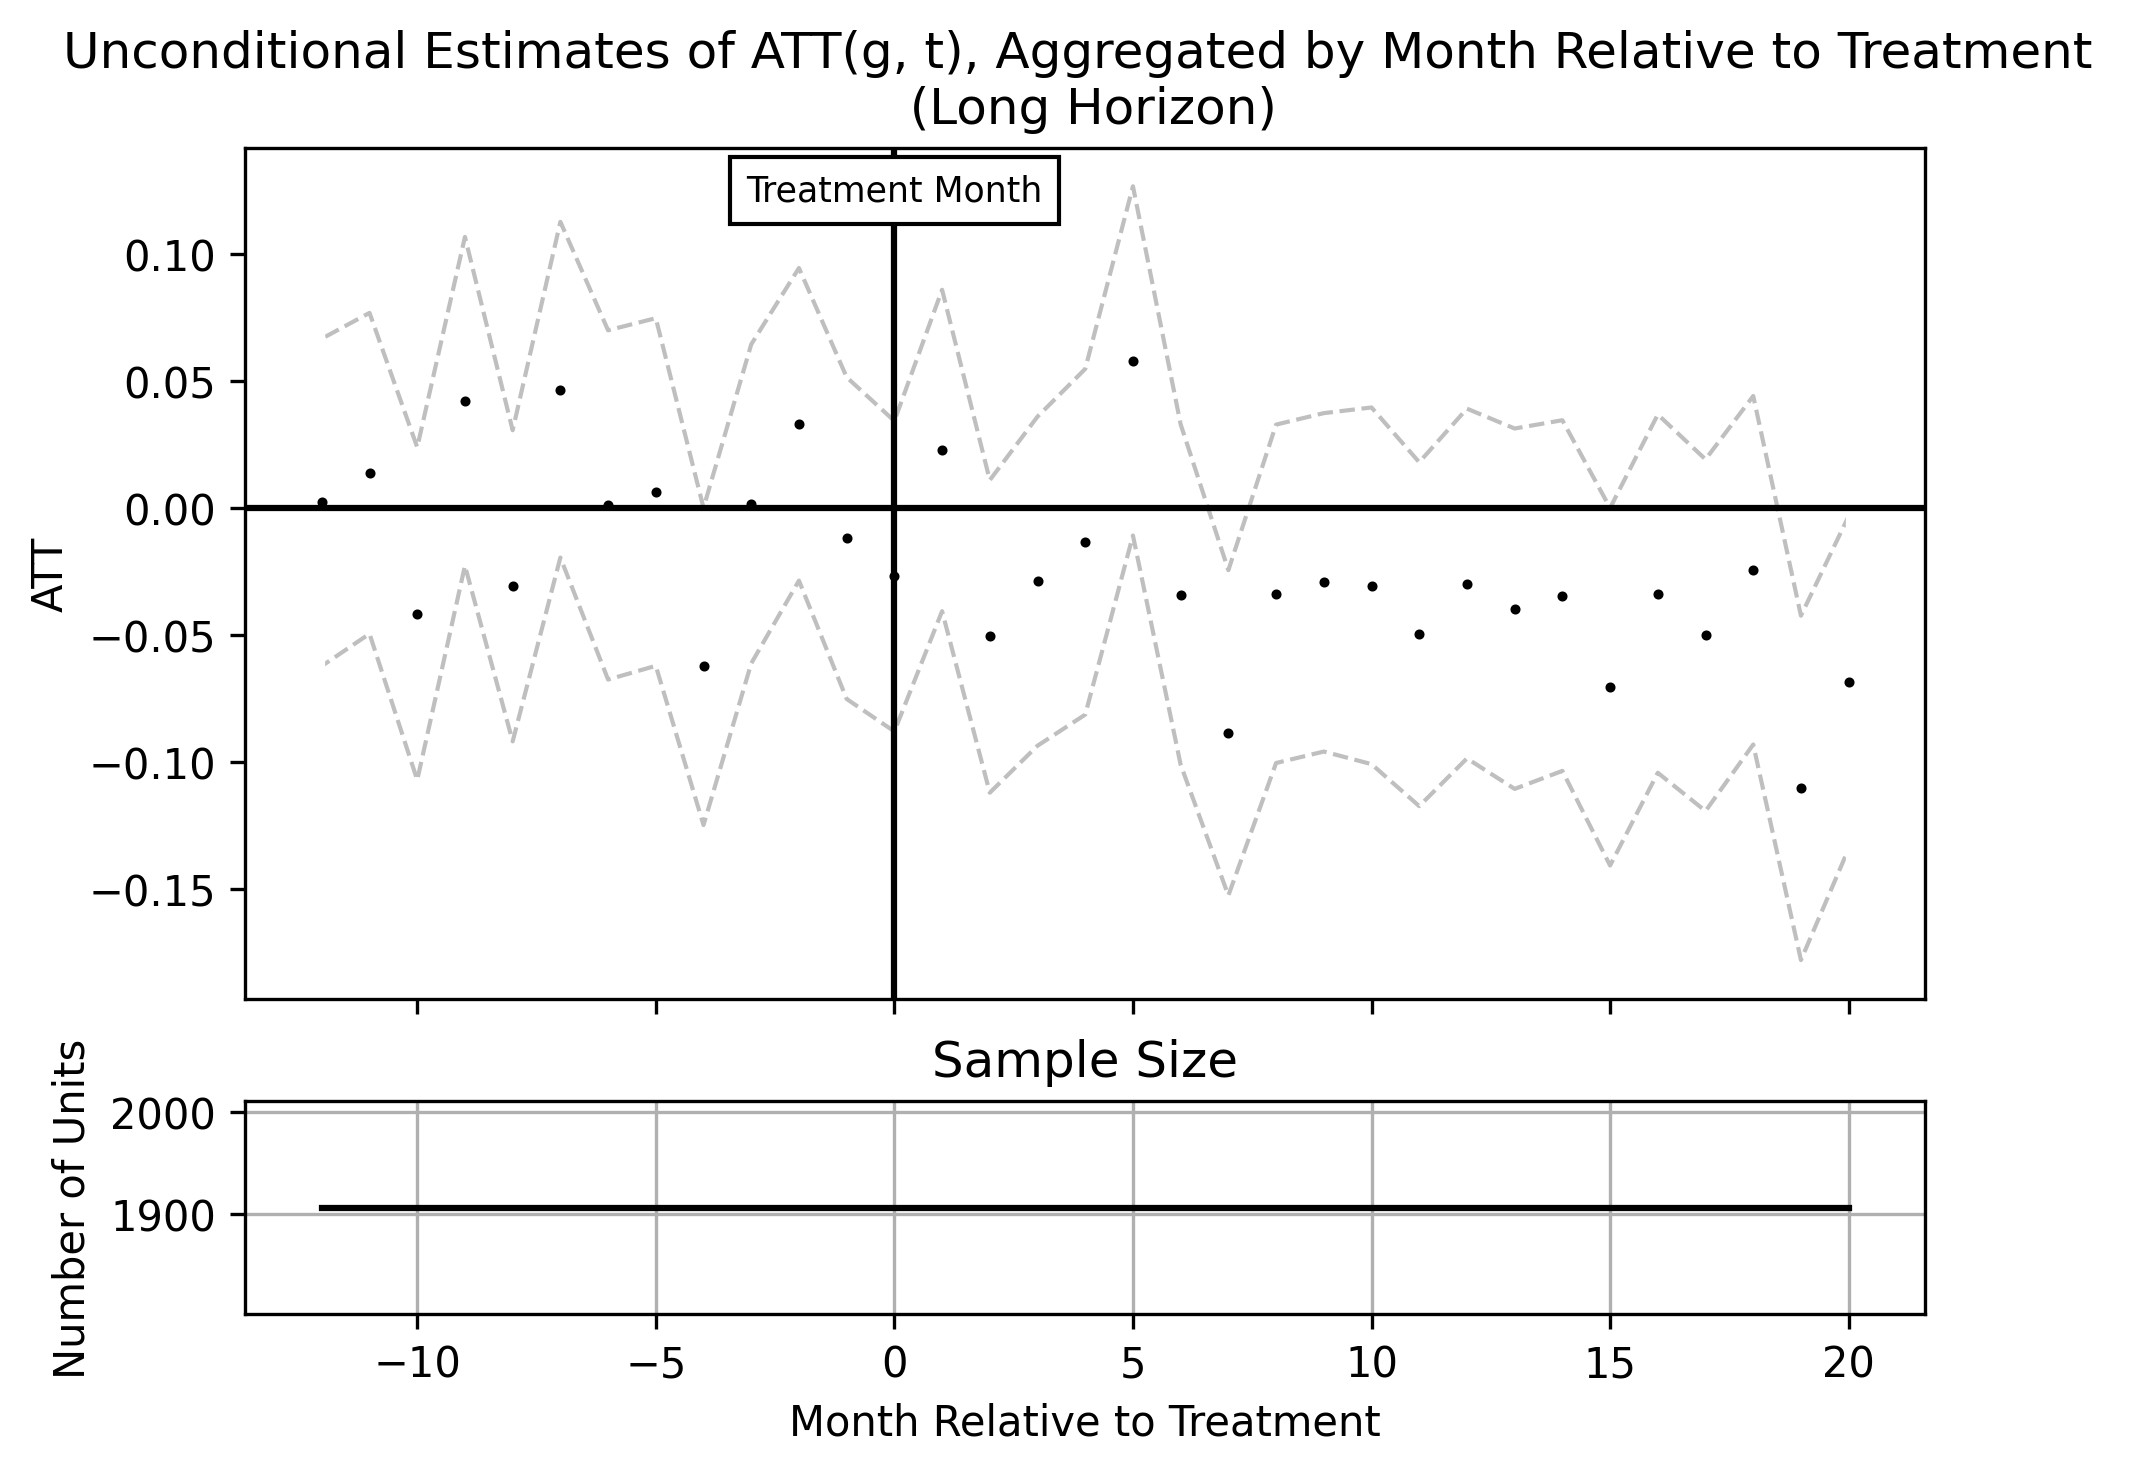

In [8]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-12, end_period=20,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

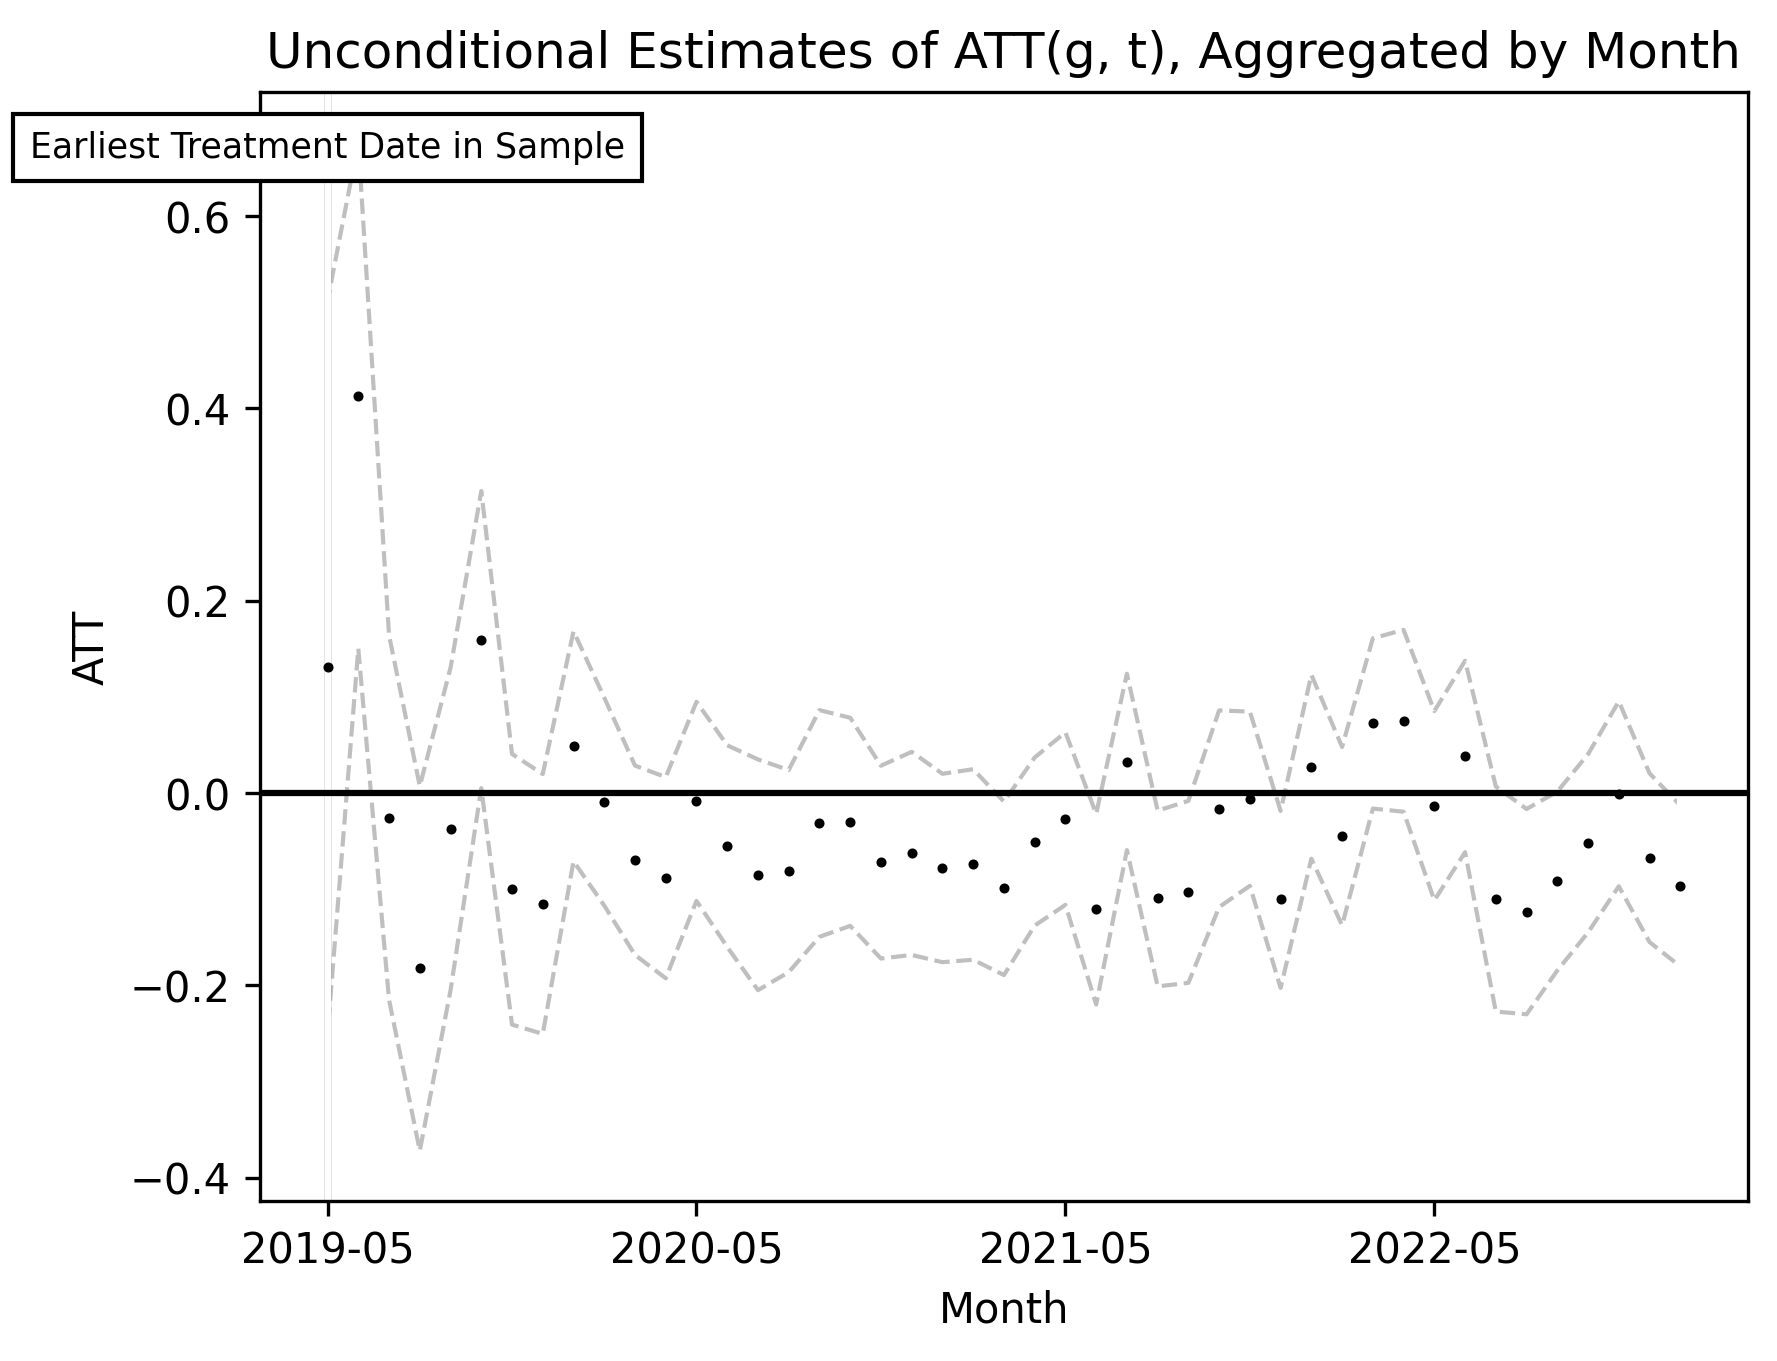

In [9]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="Unconditional Estimates of ATT(g, t), Aggregated by Month")

In [10]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_month_variable, freq='M')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]   62%|████████████▎       | 1350/2184 [00:17<00:08, 100.59it/s]/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
Computing ATTgt [workers=10]   63%|████████████▌       | 1366/2184 [00:17<00:08, 98.56it/s] /Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/python3.9/site-packages/statsmodels/genmod/families/links.py:187: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/Users/arjunshanmugam/Documents/GitHub/seniorthesis/venv/lib/pyt

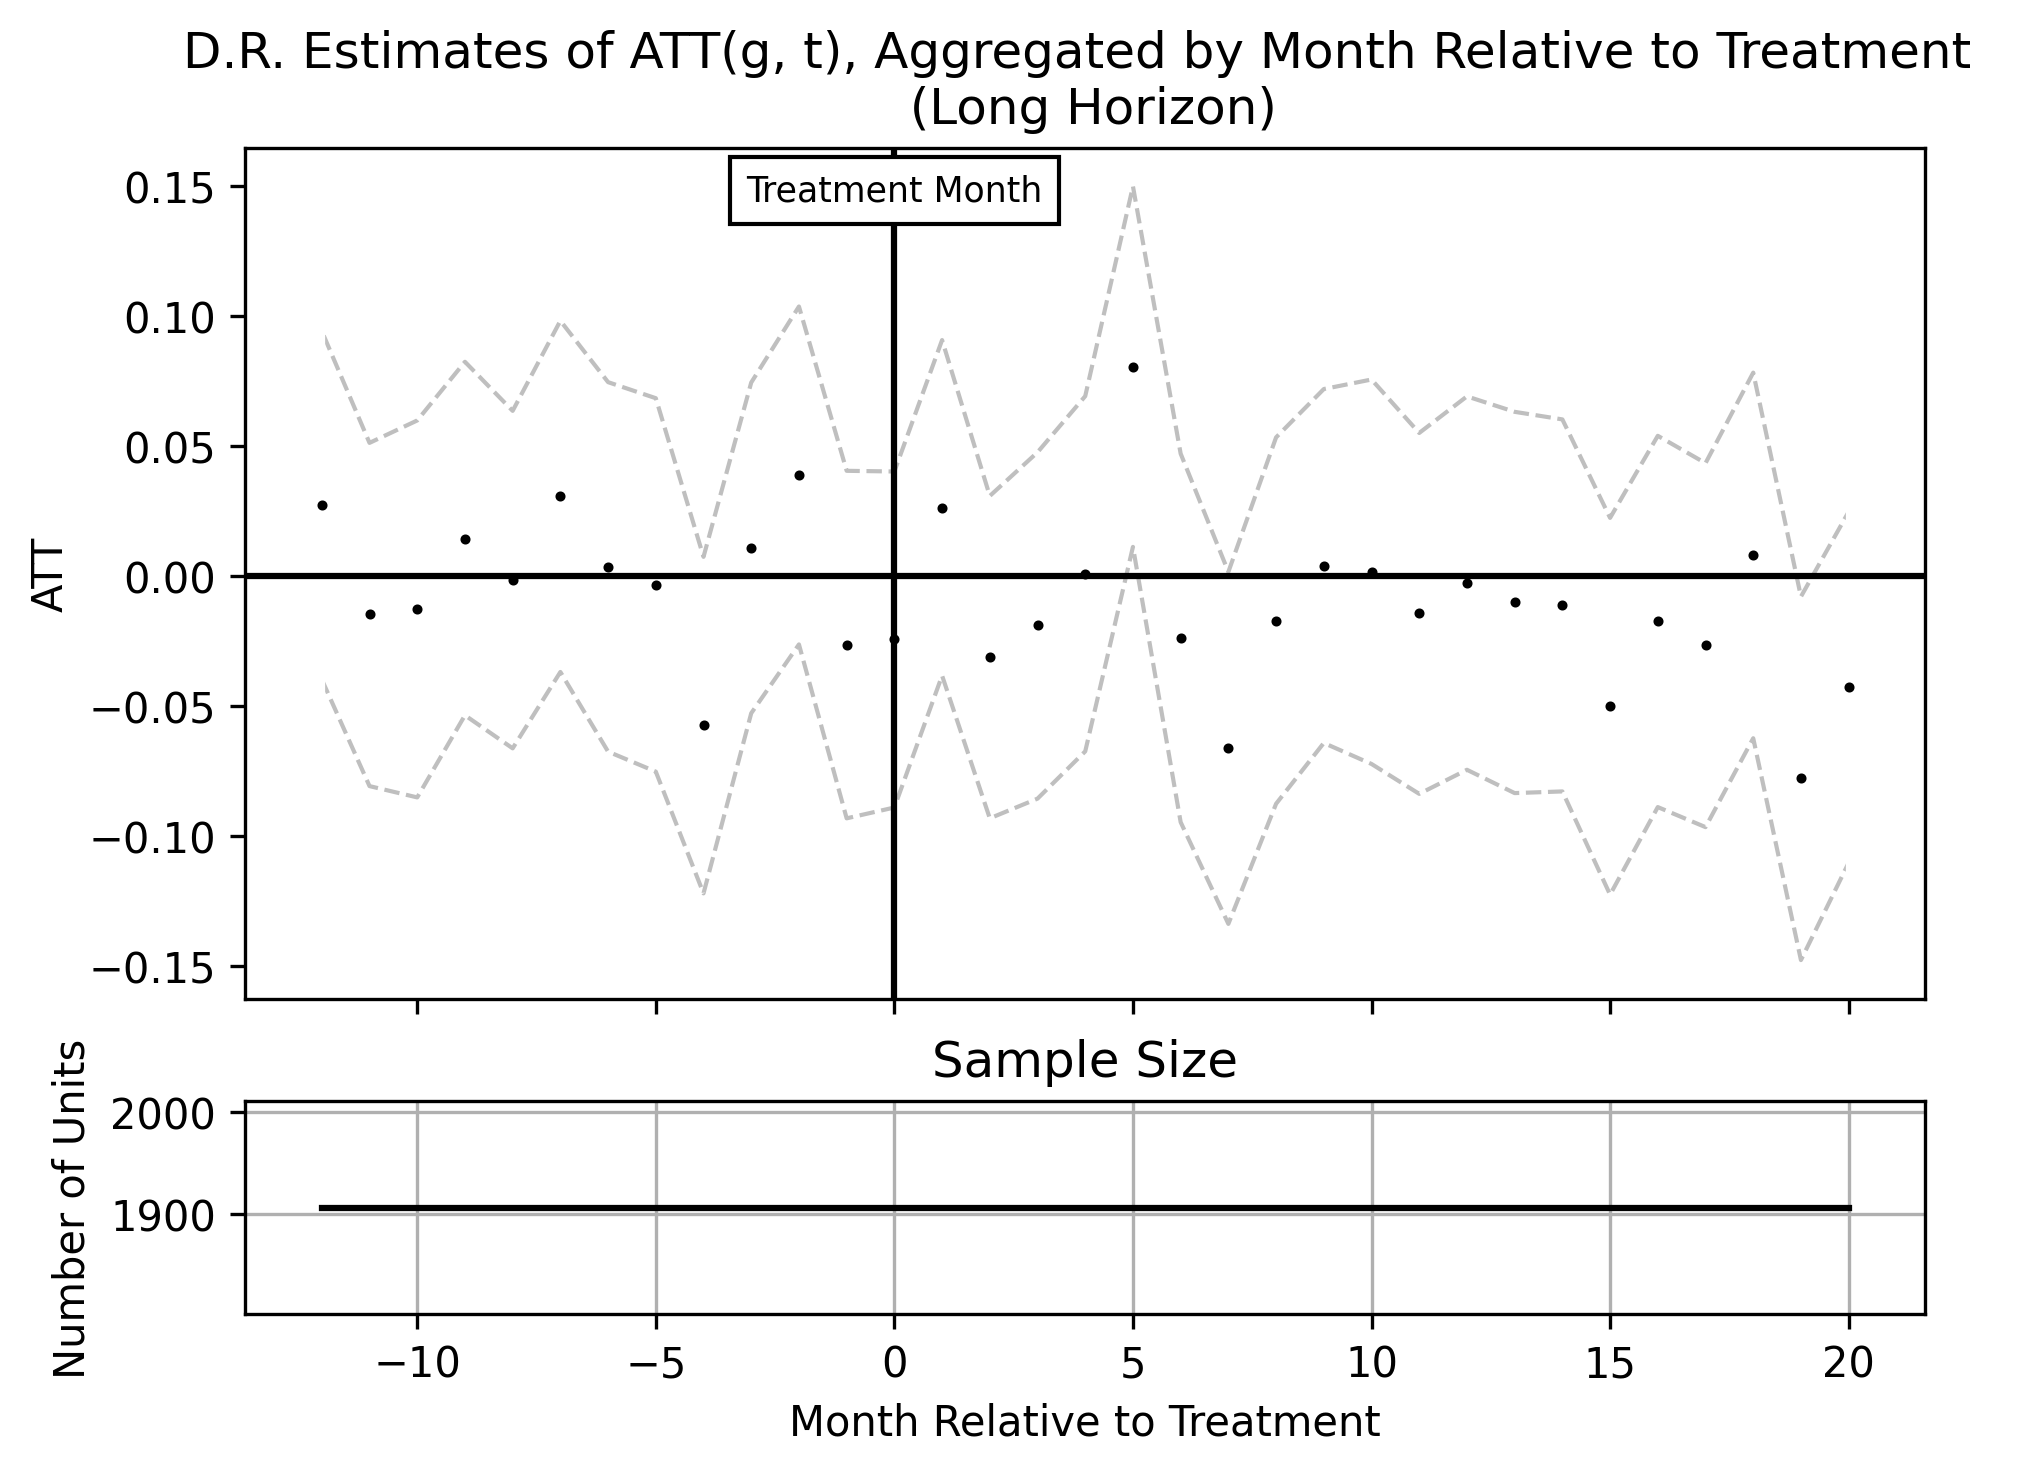

In [11]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-12,
                                 end_period=20,
                                 title="D.R. Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_month_variable, df=df)

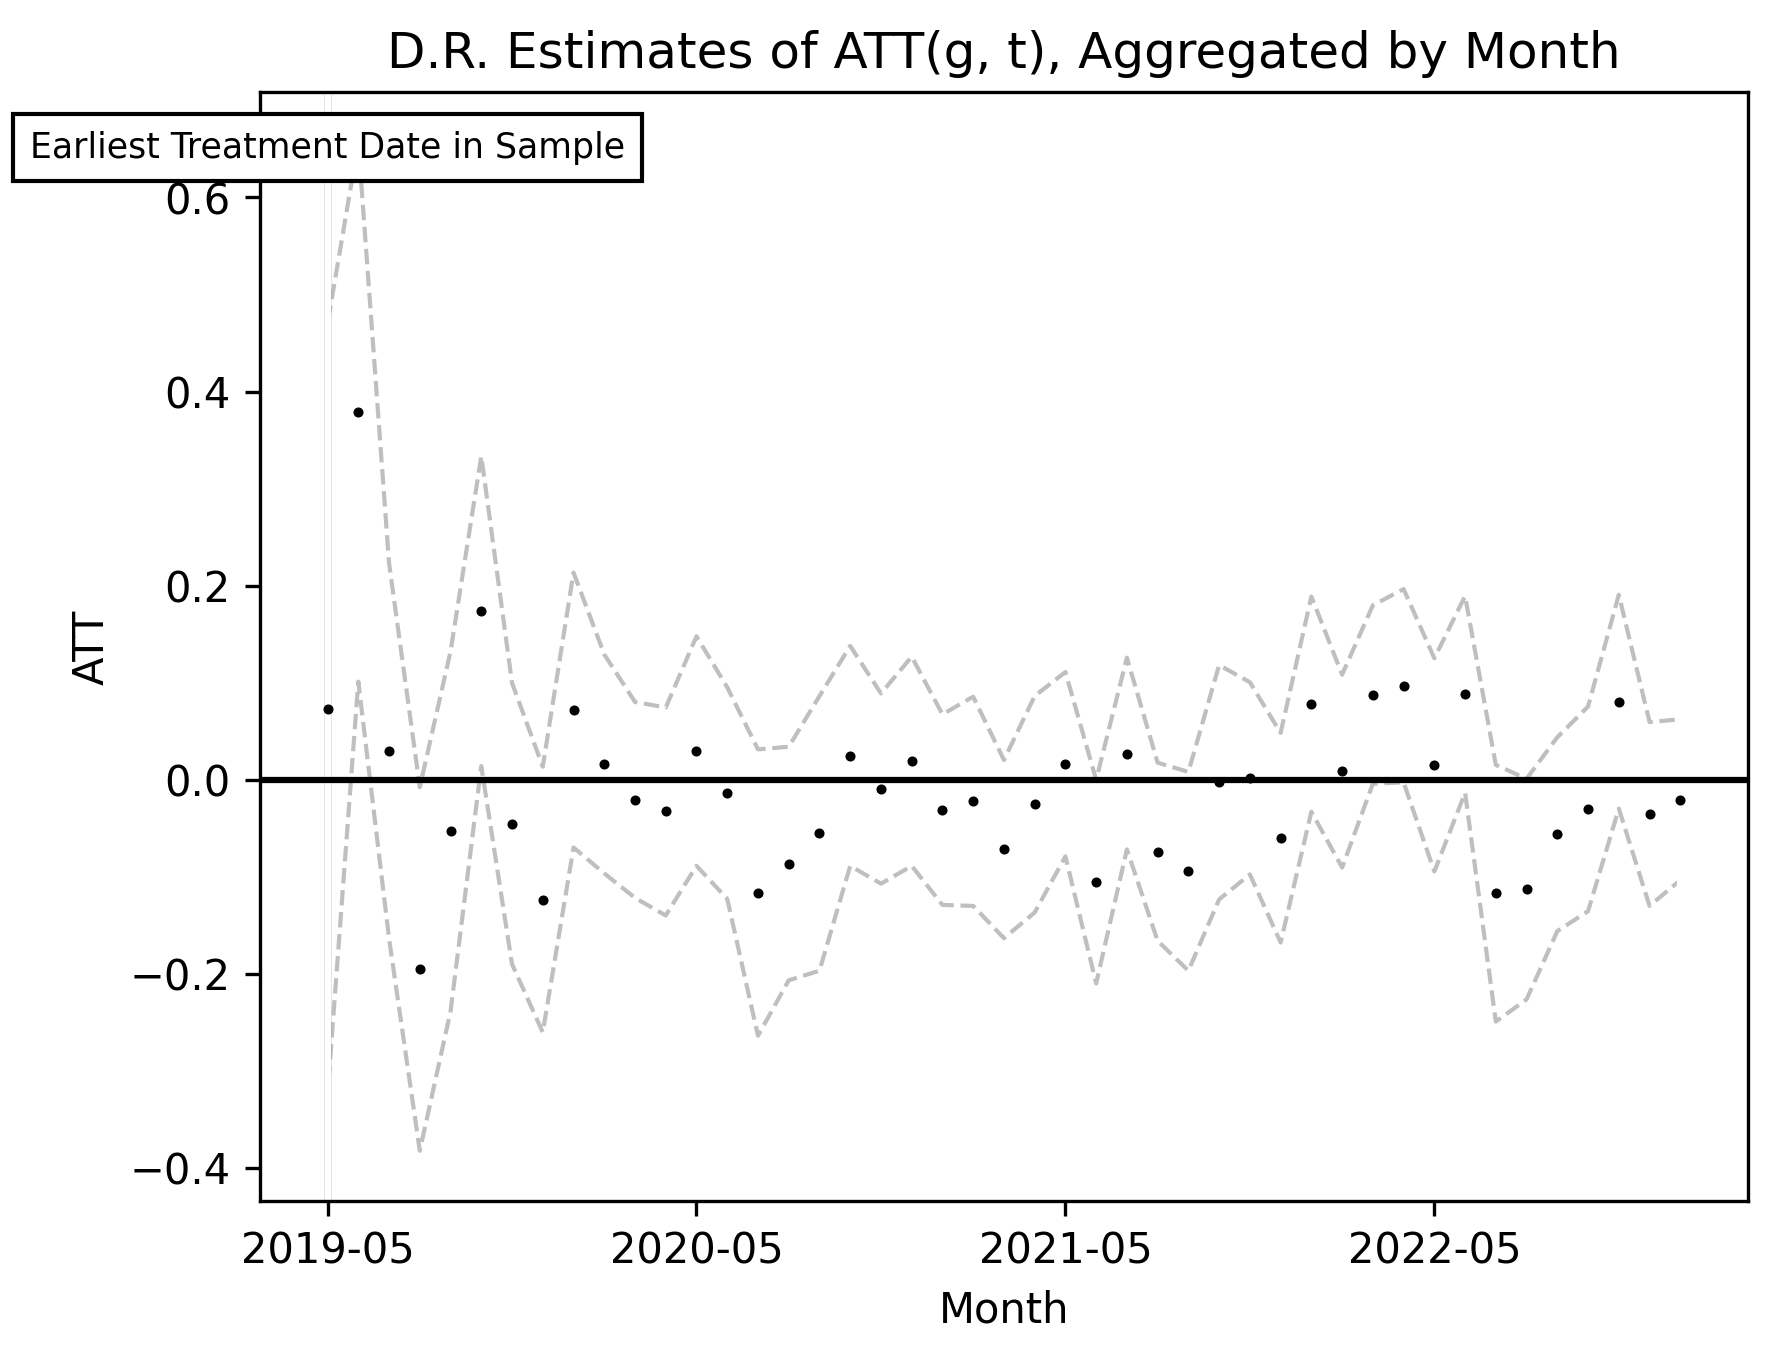

In [12]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="D.R. Estimates of ATT(g, t), Aggregated by Month")